
This notebook uses the output of the rule
--- 75_assm_stats.smk::aggregate_quast_reports
as input, and produces panels for figure 1.

Execution directory:  /home/ebertp/work/code/marschall-lab/project-male-assembly/notebooks/plotting/errors
Working directory:  /home/ebertp/work/projects/sig_chry/paper
Output directory:  /home/ebertp/work/projects/sig_chry/paper/output/figures
Dumping figures to /home/ebertp/work/projects/sig_chry/paper/output/figures


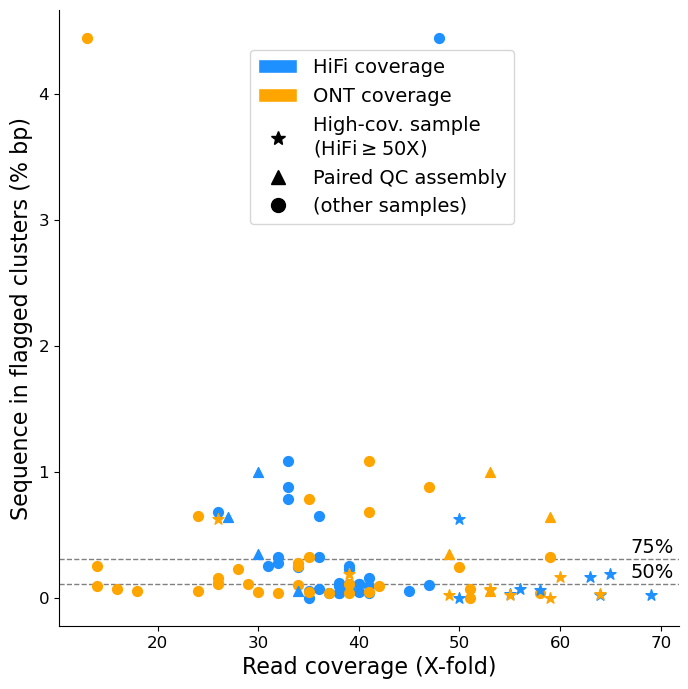

In [3]:
import pathlib as pl
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import matplotlib.lines as line
import json
import pandas as pd

# required to have text output as "text fields"
# and not individual objects
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

save_plots = True

desc="""
This notebook uses the output of the rule
--- 75_assm_stats.smk::aggregate_quast_reports
as input, and produces panels for figure 1.
"""

print(desc)

def find_repo_base(start_path):
    check_path = start_path
    while 1:
        if check_path.name == "project-male-assembly":
            return check_path
        check_path = check_path.parent
    return


exec_dir = pl.Path('.').resolve(strict=True)
paths_json = exec_dir.parent.joinpath("plotting_paths.json").resolve(strict=True)
plotting_paths = json.load(open(paths_json))

repo_dir = find_repo_base(exec_dir)
wd_dir = pl.Path(plotting_paths["wd_dir"]).resolve(strict=True)
out_dir = pl.Path(plotting_paths["fig_out"]).resolve(strict=True)

print('Execution directory: ', exec_dir)
print('Working directory: ', wd_dir)
print('Output directory: ', out_dir)
print('=================================')

cov_column = 'cov_geq_0bp_T2TXYM_linear'
err_column = ''

read_stats_file = wd_dir.joinpath('data', 'read_stats', 'SAMPLES.READS.read-stats.tsv')
read_stats = pd.read_csv(read_stats_file, header=0, sep='\t')

# Update 2023-03-30
# previous version, before NucFreq regions were added
#error_stats_file = wd_dir.joinpath('data', 'error_stats', 'SAMPLES.HIFIRW.ONTUL.na.chrY.error-stats.tsv')
#error_stats = pd.read_csv(error_stats_file, sep='\t', header=0, comment='#')

error_stats_file = wd_dir.joinpath(
    "data", "error_regions", "sample_stats",
    "SAMPLES.HIFIRW.ONTUL.na.chrY.flagged-stats.tsv"
)
error_stats = pd.read_csv(error_stats_file, sep='\t', header=0, comment='#')

read_stats = read_stats.merge(error_stats, left_on='sample', right_on='sample', how='outer')

select_hifi = read_stats['read_type'] == 'HIFIRW'
select_ont = read_stats['read_type'] == 'ONTUL'

select_high_cov = (read_stats['cov_geq_0bp_T2TXYM_linear'] >= 50) & select_hifi

hc_samples = read_stats.loc[select_high_cov, 'sample'].values
qc_samples = ['HG01457', 'HG02666', 'NA18989', 'NA19384']

select_hc = read_stats['sample'].isin(hc_samples)
select_qc = read_stats['sample'].isin(qc_samples)
other_samples = read_stats.loc[~(select_hc | select_qc), 'sample'].values
select_other = read_stats['sample'].isin(other_samples)

percentiles = [0.25, 0.5, 0.75, 0.9]

# Update 2023-03-30
# previous version, before NucFreq regions were added
#read_stats_errors = read_stats.drop_duplicates('sample', inplace=False)
#read_stats_errors_desc = read_stats_errors['error_bp_per_kbp'].describe(percentiles=percentiles)

read_stats_errors = read_stats.drop_duplicates('sample', inplace=False)
read_stats_errors_desc = read_stats_errors['mixed_region_clusters_pct'].describe(percentiles=percentiles)


pct_50 = read_stats_errors_desc["50%"]
pct_75 = read_stats_errors_desc["75%"]

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(
    read_stats.loc[select_hifi & select_other, cov_column],
    read_stats.loc[select_hifi & select_other, 'mixed_region_clusters_pct'],
    c='dodgerblue',
    label='HiFi',
    marker='o',
    s=50
)

ax.scatter(
    read_stats.loc[select_ont & select_other, cov_column],
    read_stats.loc[select_ont & select_other, 'mixed_region_clusters_pct'],
    c='orange',
    label='ONT',
    marker='o',
    s=50
)

ax.scatter(
    read_stats.loc[select_hifi & select_hc, cov_column],
    read_stats.loc[select_hifi & select_hc, 'mixed_region_clusters_pct'],
    c='dodgerblue',
    label='HiFi',
    marker='*',
    s=70
)

ax.scatter(
    read_stats.loc[select_ont & select_hc, cov_column],
    read_stats.loc[select_ont & select_hc, 'mixed_region_clusters_pct'],
    c='orange',
    label='ONT',
    marker='*',
    s=70
)

ax.scatter(
    read_stats.loc[select_hifi & select_qc, cov_column],
    read_stats.loc[select_hifi & select_qc, 'mixed_region_clusters_pct'],
    c='dodgerblue',
    label='HiFi',
    marker='^',
    s=50
)

ax.scatter(
    read_stats.loc[select_ont & select_qc, cov_column],
    read_stats.loc[select_ont & select_qc, 'mixed_region_clusters_pct'],
    c='orange',
    label='ONT',
    marker='^',
    s=50
)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.axhline(
    pct_50,
    0, 1,
    ls='dashed',
    lw=1,
    zorder=0,
    color='grey'
)

ax.axhline(
    pct_75,
    0, 1,
    ls='dashed',
    lw=1,
    zorder=0,
    color='grey'
)

ax.text(67, pct_50 + 0.05, s='50%', fontsize=14)
ax.text(67, pct_75 + 0.05, s='75%', fontsize=14)

legend_artists = []
legend_artists.extend([
    patch.Patch(facecolor='dodgerblue', edgecolor='white', label='HiFi coverage'),
    patch.Patch(facecolor='orange', edgecolor='white', label='ONT coverage'),
    line.Line2D(
        [0], [0], lw=0, marker='*', color='black', markersize=10,
        label='High-cov. sample\n' + r'(HiFi$\geq$50X)'
    ),
    line.Line2D(
        [0], [0], lw=0, marker='^', color='black', markersize=10,
        label='Paired QC assembly'
    ),
    line.Line2D(
        [0], [0], lw=0, marker='o', color='black', markersize=10,
        label='(other samples)'
    ),
])

legend = ax.legend(
    handles=legend_artists,
    bbox_to_anchor=(0.75, 0.95),
    fontsize=14)

ax.set_xlabel('Read coverage (X-fold)', fontsize=16)
ax.set_ylabel('Sequence in flagged clusters (% bp)', fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=12)

if save_plots:
    print(f"Dumping figures to {out_dir}")
    plot_name = 'FigS4_readcov_vs_errorpct'
    plt.savefig(
        out_dir / pl.Path(f'{plot_name}.pdf'),
        bbox_inches='tight',
        transparent=None,
        facecolor="w"
    )
    plt.savefig(
        out_dir / pl.Path(f'{plot_name}.png'),
        bbox_inches='tight',
        dpi=300,
        transparent=None,
        facecolor="w"
    )
